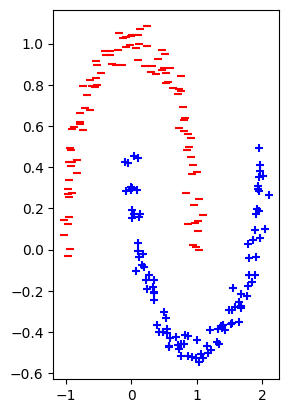

In [1]:
import os
import os
os.chdir('/Users/naji/phd_codebase/')
import sys
sys.path.append('/Users/naji/phd_codebase/')
sys.path.append('/Users/naji/phd_codebase/lpu')
sys.path.append('/Users/naji/phd_codebase/lpu/models/')
sys.path.append('/Users/naji/phd_codebase/lpu/utils')

INTRINSIC_KERNEL_PARAMS = {'normed': False, 'kernel_type': 'laplacian', 'heat_temp': .7, 'noise_factor': .0, 
                        'amplitude': 1., 'n_neighbor': 5, 'lengthscale': 1., 'neighbor_mode': 'connectivity',
                        'power_factor': 1}



import sklearn.model_selection
import numpy as np

import torch
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
import lpu.SSL.GGPC as GGPC

np.random.seed(5)
X, y = make_moons(n_samples=200, noise=0.05)
X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)    
y_bool = y.bool()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
plt.subplot(1,2,1)

plt.scatter(X[y_bool, 0], X[y_bool, 1],marker='+',c='blue')
plt.scatter(X[~y_bool, 0], X[~y_bool, 1],marker='_',c='red')



In [2]:
# Fit the model
# Usage
# Initialize inducing points
# Generate a shuffled set of indices for X_u
n_inducing_points = 100
shuffled_indices = torch.randperm(X.size(0))
# Select the first n_inducing_points based on the shuffled indices
inducing_points = X[shuffled_indices[:n_inducing_points]]    

# Assuming inducing_points is defined and is a tensor
ggpc = GGPC.GGPC(inducing_points, INTRINSIC_KERNEL_PARAMS)

ggpc.fit(X_train, y_train)

# Determine the bounds of your input space
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# Create a meshgrid for the input space
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30), np.linspace(y_min, y_max, 30))

# Flatten the grid to pass through the model
grid = np.vstack([xx.ravel(), yy.ravel()]).T
grid_tensor = torch.tensor(grid, dtype=torch.float64)
# Ensure the model and likelihood are in evaluation mode
ggpc.model.eval()
ggpc.likelihood.eval()

# Get the predictive distribution for the grid points
observed_pred = ggpc.predict_proba(grid_tensor)
pred_probs = observed_pred.reshape(xx.shape)




# Plot the decision boundary or probability contours
# For decision boundary, use levels=[0.5] if pred_probs represents probabilities
plt.contourf(xx, yy, pred_probs, levels=10, cmap='RdBu', alpha=0.5)
plt.colorbar()
plt.contour(xx, yy, pred_probs, levels=[0.5], colors='k', linestyles='--')  # Decision boundary

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Decision Boundary and Probability Contours, balanced data')

# Filter the positive examples and keep all negative examples
positive_indices = np.where(y_train == 1)[0][:2]  # Get indices of first two positive examples
subset_indices = np.concatenate((positive_indices, np.where(y_train == 0)[0]))

# Create the subset of X_train and y_train
X_subset = X_train[subset_indices]
y_subset = y_train[subset_indices]


# Assuming inducing_points is defined and is a tensor
ggpc_2 = GGPC.GGPC(inducing_points, INTRINSIC_KERNEL_PARAMS)
# Train the model on the subset
ggpc_2.fit(X_subset, y_subset)
observed_pred_2 = ggpc_2.predict_proba(grid_tensor)
# Get the predicted probabilities for class 1
pred_probs_2 = observed_pred_2.reshape(xx.shape)
plt.subplot(1, 2, 2)

# Plot the original data
plt.scatter(X_subset[y_subset.bool(), 0], X_subset[y_subset.bool(), 1], marker='+', c='blue', label='Pos Data')
plt.scatter(X_subset[~y_subset.bool(), 0], X_subset[~y_subset.bool(), 1], marker='_', c= 'red', label='Neg Data')

plt.contourf(xx, yy, pred_probs_2, levels=10, cmap='RdBu', alpha=0.5)
plt.colorbar()
plt.contour(xx, yy, pred_probs_2, levels=[0.5], colors='k', linestyles='--')  # Decision boundary

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Decision Boundary and Probability Contours: 2 positive examples only')

plt.legend()
plt.show()


KeyError: 'invert_M_first'